CRNN Base Structure (TODO Training and Accuracy)

In [1]:
# Import required libraries
import numpy as np
import torch
import torch.nn as nn

In [2]:
# Base structure of CRNN
class CRNN(nn.Module):
    def __init__(self):
        super(CRNN, self).__init__()
        self.features = nn.Sequential (
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,3)),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.MaxPool2d((2,2)),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3)),
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3)),
            nn.BatchNorm2d(256),
            nn.ELU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3)),
            nn.BatchNorm2d(256),
            nn.ELU(),
            nn.MaxPool2d((2, 2)),
        )

        final_conv_height = 6
        final_conv_width = 5
        gru_input_size = 256 * final_conv_width

        totalInstruments = 3

        self.gru = nn.GRU(
            input_size=768, 
            hidden_size=256, 
            batch_first=True
        )
        # out_features is technically 18 in paper, but realistically 3 at the beginning
        self.fc = nn.Linear(in_features=256, out_features=totalInstruments)
        
    def forward(self, input):
        # Pass input through convolutional layers
        conv_output = self.features(input)
        
        # Get the batch size (B), and the number of feature maps (C), height (H), and width (W)
        B, C, H, W = conv_output.size()

        # Reshape the output to treat the height 'H' as the sequence and combine the channels
        # and width 'W' as features, which should have been calculated as 256*5
        # Here we assume each timestep corresponds to a row in the feature maps
        x = conv_output.view(B, H, C * W)  # Shape: (B, H, C*W)

        # Pass the reshaped conv_output to the GRU
        gru_output, _ = self.gru(x)

        # Usually, you'd take just the last time step
        last_time_step_output = gru_output[:, -1, :]

        # Pass that through your fully connected layer
        output = self.fc(last_time_step_output)

        return output
    
    def save_model(self, path: str):
        torch.save(self.state_dict(), path)

    def load_model(*parameters, path: str):
        loaded_model = CRNN(parameters)
        loaded_model.load_state_dict(torch.load(path))
        return loaded_model

In [3]:
# Future stuff for training and accuracy of CNN
import torch.optim as optim

model = CRNN()
lossAlg = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.0001, momentum=0.9)

In [9]:
from torch.utils.data import DataLoader, Dataset, random_split
import logging, sys
import os
import h5py
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from typing import Tuple

# Import files based off hdf5

In [10]:
class FrameDataset(Dataset):
    def __init__(self, path):
        self.file_path = path
        self.file = h5py.File(self.file_path, 'r')
        self.features = self.file['features']
        self.labels = self.file['labels']

    def __len__(self):
        return int(self.file['overall_metadata'][2])

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx], dtype=torch.float32).reshape(1, 96, 87)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return feature, label
    
    def close(self):
        self.file.close()



In [21]:
# Training the model
import time
logging.basicConfig(stream=sys.stderr, level=logging.INFO)

def train_model(
        model, train_dataloader, validation_dataloader, criterion, optimizer, epochs = 1
) -> Tuple[list, list]:
    train_accuracies = []
    validation_accuracies = []

    start_time = time.time()

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}")
        model.train()

        total_loss = 0
        correct_predictions = 0
        total_predictions = 0

        for data, labels in train_dataloader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = torch.sigmoid(outputs) > 0.5
            correct_predictions += (predicted == labels).float().sum()
            total_predictions += torch.numel(labels)

        train_accuracy = correct_predictions / total_predictions
        train_accuracies.append(train_accuracy.item())

        model.eval()
        with torch.no_grad():
            correct_predictions = 0
            total_predictions = 0
            for data, labels in validation_dataloader:
                outputs = model(data)
                predicted = torch.sigmoid(outputs) > 0.5
                correct_predictions += (predicted == labels).float().sum()
                total_predictions += torch.numel(labels)

            validation_accuracy = correct_predictions / total_predictions
            validation_accuracies.append(validation_accuracy)

        # Time remaining counter
        time_remaining = (epochs - (epoch+1)) * (
            time.time() - start_time
        )/(epoch+1)
        hours, remainder = divmod(time_remaining, 3600)
        minutes, seconds = divmod(remainder, 60)
        # Formatted time output
        print(
            f"Time remaining: {int(hours):02}:{int(minutes):02}:{int(seconds):02}"
        )
    
    return train_accuracies, validation_accuracies

def plot_accuracy(
        train_accuracies:list, validation_accuracies:list, epoch_count: int
):
    epochs = range(1, epoch_count+1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, label="Training Accuracy")
    plt.plot(epochs, validation_accuracies, label="Validation Accuracy")
    plt.title("CRNN Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

def test_model(model, test_dataloader):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        correct_predictions = 0
        total_predictions = 0
        for data, labels in test_dataloader:
            outputs = model(data)
            predicted = torch.sigmoid(outputs) > 0.5
            correct_predictions += (predicted == labels).float().sum()
            total_predictions += torch.numel(labels)

In [18]:
train_dataset = FrameDataset('trainData.h5')
test_dataset = FrameDataset('testData.h5')

train_size = int(0.8*len(train_dataset))
validation_size = len(train_dataset) - train_size

train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=True)

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [19]:
train_acc, valid_acc = train_model(model=model, train_dataloader=train_dataloader, validation_dataloader=validation_dataloader, criterion=lossAlg, optimizer=optimizer, epochs=20)

Epoch 1
Time remaining: 00:54:48
Epoch 2
Time remaining: 00:55:35
Epoch 3
Time remaining: 01:08:28
Epoch 4
Time remaining: 01:08:51
Epoch 5
Time remaining: 01:05:48
Epoch 6
Time remaining: 00:58:30
Epoch 7
Time remaining: 00:52:57
Epoch 8
Time remaining: 00:47:20
Epoch 9
Time remaining: 00:41:51
Epoch 10
Time remaining: 00:37:01
Epoch 11
Time remaining: 00:32:34
Epoch 12
Time remaining: 00:28:19
Epoch 13
Time remaining: 00:24:16
Epoch 14
Time remaining: 00:20:21
Epoch 15
Time remaining: 00:16:39
Epoch 16
Time remaining: 00:13:05
Epoch 17
Time remaining: 00:09:40
Epoch 18
Time remaining: 00:06:21
Epoch 19
Time remaining: 00:03:08
Epoch 20
Time remaining: 00:00:00


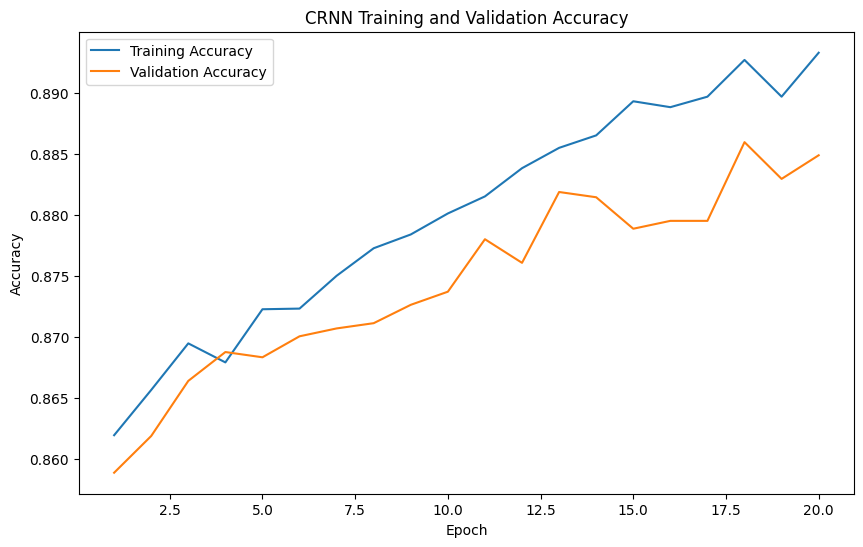

0.8932753205299377


In [22]:
plot_accuracy(train_accuracies=train_acc, validation_accuracies=valid_acc, epoch_count=20)
print(train_acc[-1])